In [ ]:
# STEP 1. 설치
!pip uninstall -y numpy
!pip install numpy==1.24.4 --no-cache-dir
!pip install konlpy==0.6.0 gensim==4.3.3 jpype1==1.5.2 --quiet
!apt-get update -qq
!apt-get install -y fonts-nanum openjdk-11-jdk



Found existing installation: numpy 1.24.4
Uninstalling numpy-1.24.4:
  Successfully uninstalled numpy-1.24.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 81.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.2 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
tsfresh 0.21.0 requires s

^C
^C


Saving egov_Kor.csv to egov_Kor.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

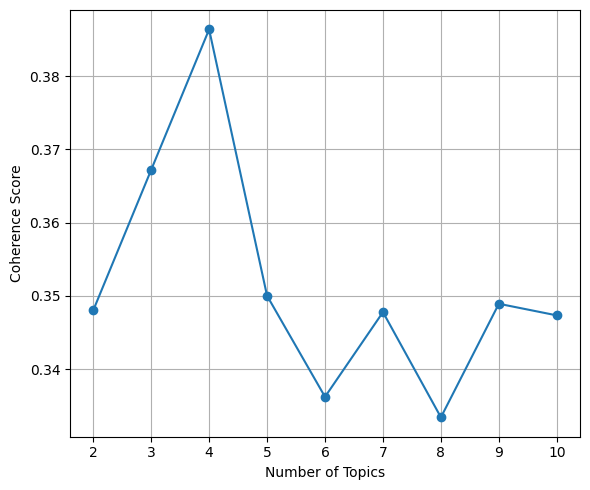

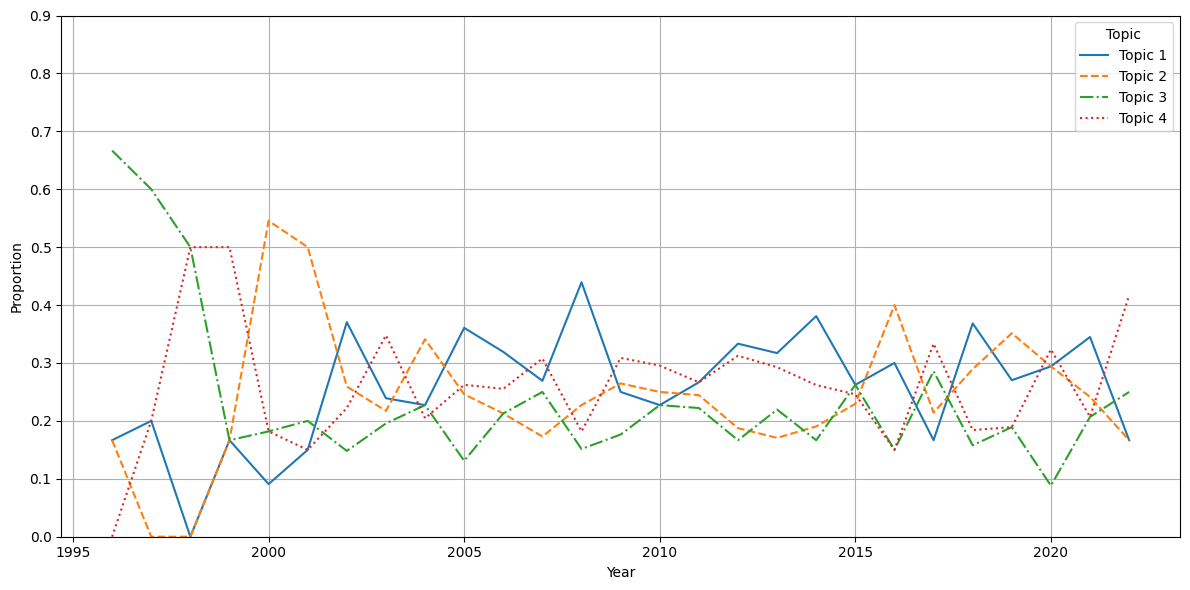

각 토픽의 전체 문서 비중:
Dominant_Topic
Topic 1    0.289959
Topic 2    0.251025
Topic 3    0.199795
Topic 4    0.259221
Name: proportion, dtype: float64


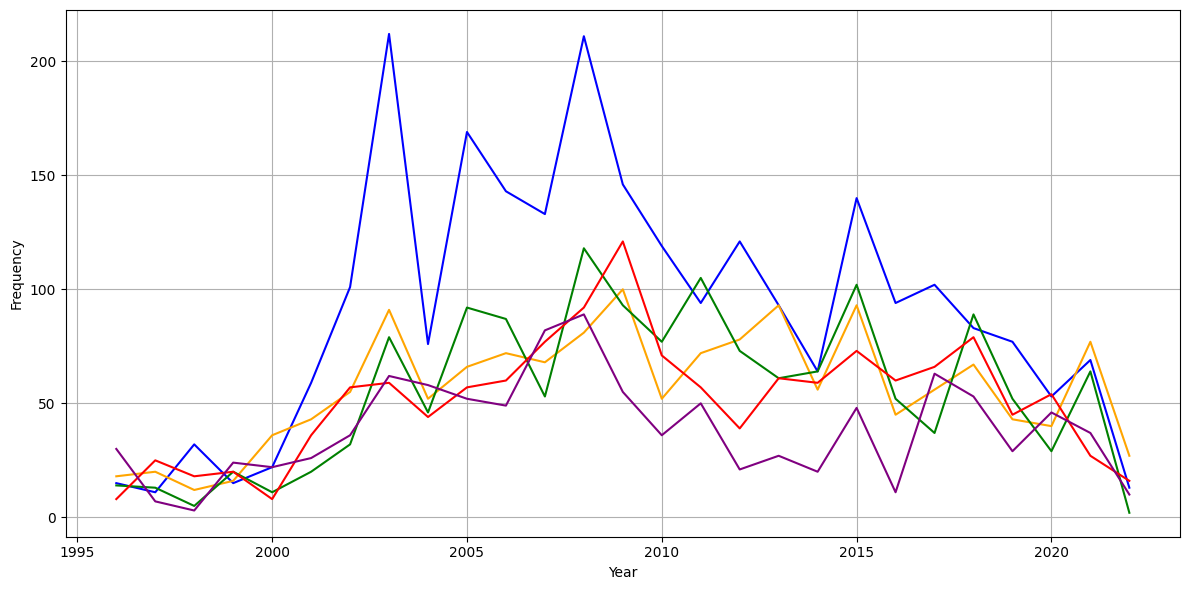

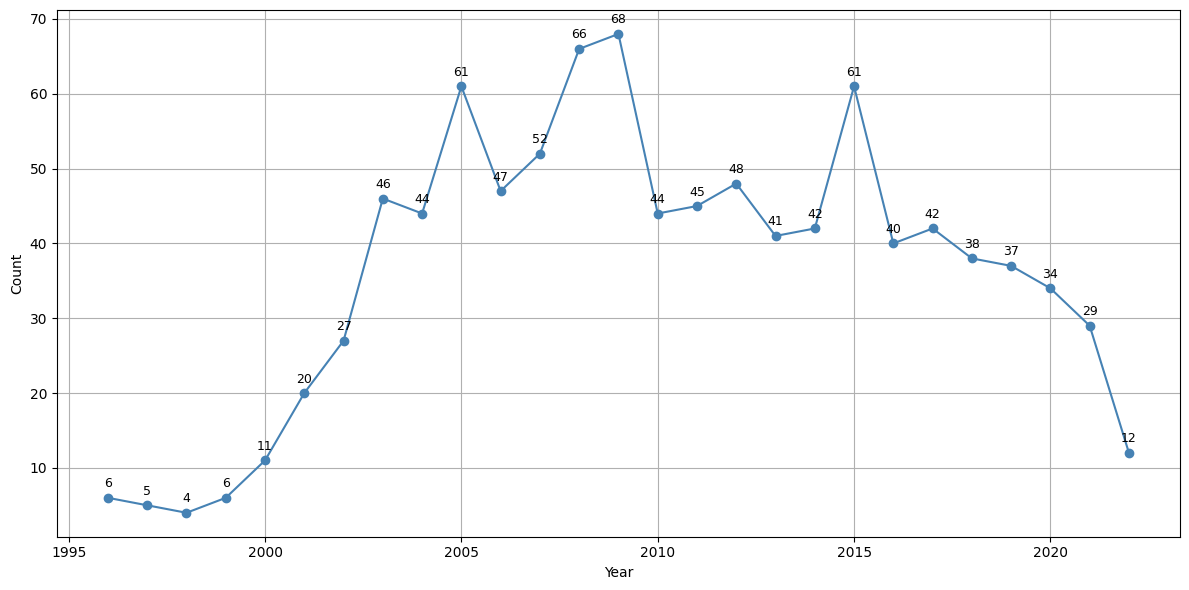

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53664 (\N{HANGUL SYLLABLE TO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54589 (\N{HANGUL SYLLABLE PIG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/loc

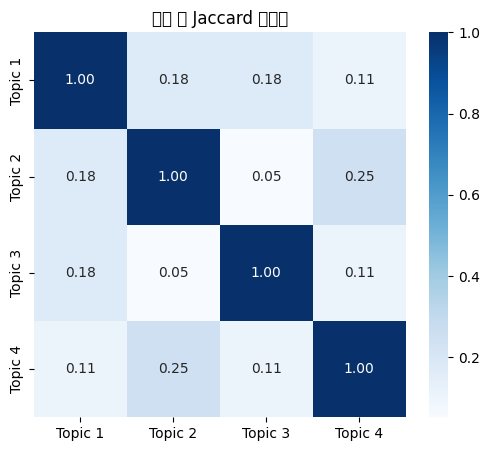

In [1]:
# STEP 2. 환경 설정
import os
import random
import numpy as np
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
random.seed(42)
np.random.seed(42)

# STEP 3. 라이브러리
import pandas as pd; import matplotlib.pyplot as plt
from konlpy.tag import Okt
from gensim import corpora, models
from gensim.models import CoherenceModel
from collections import Counter
from google.colab import files

# STEP 4. 데이터 업로드 및 전처리
uploaded = files.upload()
df = pd.read_csv("egov_Kor.csv", encoding="cp949").dropna(subset=["Abstract", "Year"])
df["Year"] = df["Year"].astype(int)
stopwords = ['것', '연구', '위', '수', '및', '분석', '대한', '등', '이', '관련', '의', '통해', '그', '위해', '기반', '점']
okt = Okt()
df["tokens"] = df["Abstract"].apply(lambda text: [word for word in okt.nouns(text) if word not in stopwords and len(word) > 1])
tokenized = df["tokens"].tolist()

# STEP 5. 키워드 빈도 저장
all_words = [word for doc in tokenized for word in doc]
top_words = Counter(all_words).most_common(20)
df_top_words = pd.DataFrame(top_words, columns=['word', 'count'])
df_top_words.to_csv('top_keywords.csv', index=False, encoding='utf-8-sig')
files.download('top_keywords.csv')

# STEP 6. 사전 및 코퍼스
dictionary = corpora.Dictionary(tokenized)
dictionary.filter_extremes(no_below=2, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in tokenized]

# STEP 7. 최적 토픽 수(Coherence)
def compute_coherence_values(dictionary, corpus, texts, start, limit):
    coherence_values = []
    for num_topics in range(start, limit + 1):
        model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, random_state=42)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return coherence_values
coherence_values = compute_coherence_values(dictionary, corpus, tokenized, 2, 10)
plt.figure(figsize=(6, 5)); plt.plot(range(2, 11), coherence_values, marker='o')
plt.xlabel("Number of Topics"); plt.ylabel("Coherence Score"); plt.grid(True); plt.tight_layout(); plt.show()

# STEP 8. LDA 학습
lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=4, passes=10, random_state=42)

# STEP 9. 대표 토픽 추출
df["bow"] = df["tokens"].apply(dictionary.doc2bow)
df["topic_dist"] = df["bow"].apply(lambda bow: lda_model.get_document_topics(bow, minimum_probability=0))
df["Dominant_Topic"] = df["topic_dist"].apply(lambda dist: max(dist, key=lambda x: x[1])[0])

# STEP 10. 연도별 토픽 비율 시각화
topic_counts = df.groupby(["Year", "Dominant_Topic"]).size().unstack(fill_value=0)
topic_props = topic_counts.div(topic_counts.sum(axis=1), axis=0)
topic_props.columns = [f"Topic {i+1}" for i in topic_props.columns]
linestyles = ['-', '--', '-.', ':']
plt.figure(figsize=(12, 6))
for i, col in enumerate(topic_props.columns):
    plt.plot(topic_props.index, topic_props[col], linestyle=linestyles[i % len(linestyles)], label=col)
plt.xlabel("Year"); plt.ylabel("Proportion"); plt.ylim(0.0, 0.9)
plt.grid(True); plt.legend(title="Topic"); plt.tight_layout(); plt.show()

# STEP 11. 전체 문서 비중
topic_distribution = df["Dominant_Topic"].value_counts(normalize=True).sort_index()
topic_distribution = topic_distribution.rename(lambda x: f"Topic {x+1}")
print("각 토픽의 전체 문서 비중:")
print(topic_distribution)

# STEP 12. 키워드 연도별 출현
target_keywords = ["전자정부", "정부", "서비스", "정보", "행정"]
yearly_freq = {kw: [] for kw in target_keywords}
years = sorted(df["Year"].unique())
for year in years:
    tokens = sum(df[df["Year"] == year]["tokens"], [])
    counter = Counter(tokens)
    for kw in target_keywords:
        yearly_freq[kw].append(counter[kw])
plt.figure(figsize=(12, 6))
for kw, color in zip(target_keywords, ["blue", "orange", "green", "red", "purple"]):
    plt.plot(years, yearly_freq[kw], color=color)
plt.xlabel("Year"); plt.ylabel("Frequency"); plt.grid(True); plt.tight_layout(); plt.show()

# STEP 13. 연도별 논문 수
year_counts = df["Year"].value_counts().sort_index()
plt.figure(figsize=(12, 6))
plt.plot(year_counts.index, year_counts.values, marker='o', color='steelblue')
for x, y in zip(year_counts.index, year_counts.values):
    plt.text(x, y + 1, str(y), ha='center', va='bottom', fontsize=9)
plt.xlabel("Year"); plt.ylabel("Count"); plt.grid(True); plt.tight_layout(); plt.show()

# STEP 14. 토픽별 키워드 저장
topic_keywords = []
for idx, terms in lda_model.show_topics(num_words=10, formatted=False):
    for word, weight in terms:
        topic_keywords.append({"Topic": f"Topic {idx+1}", "Keyword": word, "Weight": round(weight, 4)})
df_keywords = pd.DataFrame(topic_keywords)
df_keywords.to_csv("lda_topic_keywords_with_weights.csv", index=False, encoding="utf-8-sig")
files.download("lda_topic_keywords_with_weights.csv")

# STEP 15. 키워드 조합 문자열 저장
lines = []
for idx, topic in lda_model.show_topics(num_words=10, formatted=False):
    line = " + ".join([f'{weight:.3f}*"{word}"' for word, weight in topic])
    lines.append(f"Topic {idx+1}: {line}")
with open("lda_topic_keyword_strings.txt", "w", encoding="utf-8") as f:
    for line in lines:
        f.write(line + "\n")
files.download("lda_topic_keyword_strings.txt")

# STEP 16. Jaccard 유사도
from itertools import combinations; import seaborn as sns
topics_keywords = {f"Topic {idx+1}": [word for word, _ in topic] for idx, topic in lda_model.show_topics(num_words=10, formatted=False)}
def jaccard_similarity(list1, list2):
    set1, set2 = set(list1), set(list2)
    return len(set1 & set2) / len(set1 | set2)
topic_names = list(topics_keywords.keys())
jaccard_matrix = pd.DataFrame(index=topic_names, columns=topic_names)
for t1, t2 in combinations(topic_names, 2):
    score = jaccard_similarity(topics_keywords[t1], topics_keywords[t2])
    jaccard_matrix.loc[t1, t2] = score
    jaccard_matrix.loc[t2, t1] = score
for t in topic_names:
    jaccard_matrix.loc[t, t] = 1.0
plt.figure(figsize=(6, 5))
sns.heatmap(jaccard_matrix.astype(float), annot=True, cmap="Blues", fmt=".2f")
plt.title("토픽 간 Jaccard 유사도")
plt.show()

